In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import os
import cv2

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [90]:
def extract_label(img_path,train = True, medium=None):
    filename, _ = os.path.splitext(os.path.basename(img_path))

    subject_id, etc = filename.split('__')
    subject_id = int(subject_id) - 1 # for to_categorical encodes starting from 0
    # train data contain what type of noise in the end, ex. 100__M_Left_thumb_finger_Obl.BMP
    if train:
        gender, lr, finger, _, noise = etc.split('_')
        
        gender = 0 if gender == 'M' else 1
        lr = 0 if lr == 'Left' else 1

        # We want to return which finger it is
        if finger == 'thumb':
            finger = 0
        elif finger == 'index':
            finger = 1
        elif finger == 'middle':
            finger = 2
        elif finger == 'ring':
            finger = 3
        elif finger == 'little':
            finger = 4
        if medium != None:
            return np.array([finger], dtype=np.uint16), int(subject_id), noise
        else:
            return np.array([finger], dtype=np.uint16), int(subject_id)
    else:
        gender, lr, finger, _ = etc.split('_')
  
        gender = 0 if gender == 'M' else 1
        lr = 0 if lr == 'Left' else 1

        # We want to return which finger it is
        if finger == 'thumb':
            finger = 0
        elif finger == 'index':
            finger = 1
        elif finger == 'middle':
            finger = 2
        elif finger == 'ring':
            finger = 3
        elif finger == 'little':
            finger = 4
    
        return np.array([finger], dtype=np.uint16), int(subject_id)

In [91]:
img_size = 96

def loading_data(path,train,medium=None):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            if medium == None:
                label, subject_id = extract_label(os.path.join(path, img),train)
            else:
                label, subject_id, noise = extract_label(os.path.join(path, img),train, medium)
            if train:
#                 print(subject_id)
#                 if subject_id <= 500:
#                     print("training data")

                    if medium == None:
                        data.append([subject_id, img_resize])
                    else:
                        if noise == medium:
                            data.append([subject_id, img_resize])
            else:
#                 if subject_id > 500:
#                     print("testing data")
                    
                    data.append([subject_id, img_resize])
            
        except Exception as e:
            pass
    data
    return data

In [108]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

In [92]:
Real_path = "../input/socofing/SOCOFing/Real"
Easy_path = "../input/socofing/SOCOFing/Altered/Altered-Easy"
Medium_path = "../input/socofing/SOCOFing/Altered/Altered-Medium"
Hard_path = "../input/socofing/SOCOFing/Altered/Altered-Hard"


Easy_data = loading_data(Easy_path, train = True)
Hard_data = loading_data(Hard_path, train = True)
data = loading_data(Real_path, train =False)
test = loading_data(Real_path, train=False)


# it take real_data, medium_data, hard_data as training dataset 
# medium_data, gauss, sp, poisson,  as testing dataset

data = np.concatenate([Easy_data, data, Hard_data], axis=0)


del Easy_data, Hard_data

loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Easy
loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Hard
loading data from:  ../input/socofing/SOCOFing/Real
loading data from:  ../input/socofing/SOCOFing/Real


In [93]:
Medium_data_CR = loading_data(Medium_path, train = True, medium = "CR")
Medium_data_Zcut = loading_data(Medium_path, train = True, medium = "Zcut")
Medium_data_Obl = loading_data(Medium_path, train = True, medium = "Obl")

loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Medium
loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Medium
loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Medium


In [95]:
import random
random.shuffle(data)
random.shuffle(test)
random.shuffle(Medium_data_CR)
random.shuffle(Medium_data_Zcut)
random.shuffle(Medium_data_Obl)


In [96]:
print(len(data))
print(len(test))
print(len(Medium_data_CR))
print(len(Medium_data_CR))
print(len(Medium_data_CR))

38203
6000
5516
5516
5516


In [60]:

img, labels = [], []
for label, feature in data:
    labels.append(label)
    img.append(feature)
# print(img)
train_data = np.array(img).reshape(-1, img_size, img_size, 1)
train_data = train_data / 255.0 # normalize to [0, 1]
print(train_data.shape)

(38203, 96, 96, 1)


In [61]:
train_labels = to_categorical(labels, num_classes = 600)

In [62]:
del data

In [63]:
model = Sequential(name="SubjectID_Mod")

model.add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(600, activation='softmax'))

# Complete with Adam optimizer and entropy cost
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "SubjectID_Mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 92, 92, 32)        832       
_________________________________________________________________
batch_normalization_7 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
batch_normalization_8 (Batch (None, 42, 42, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 19, 19, 128)     

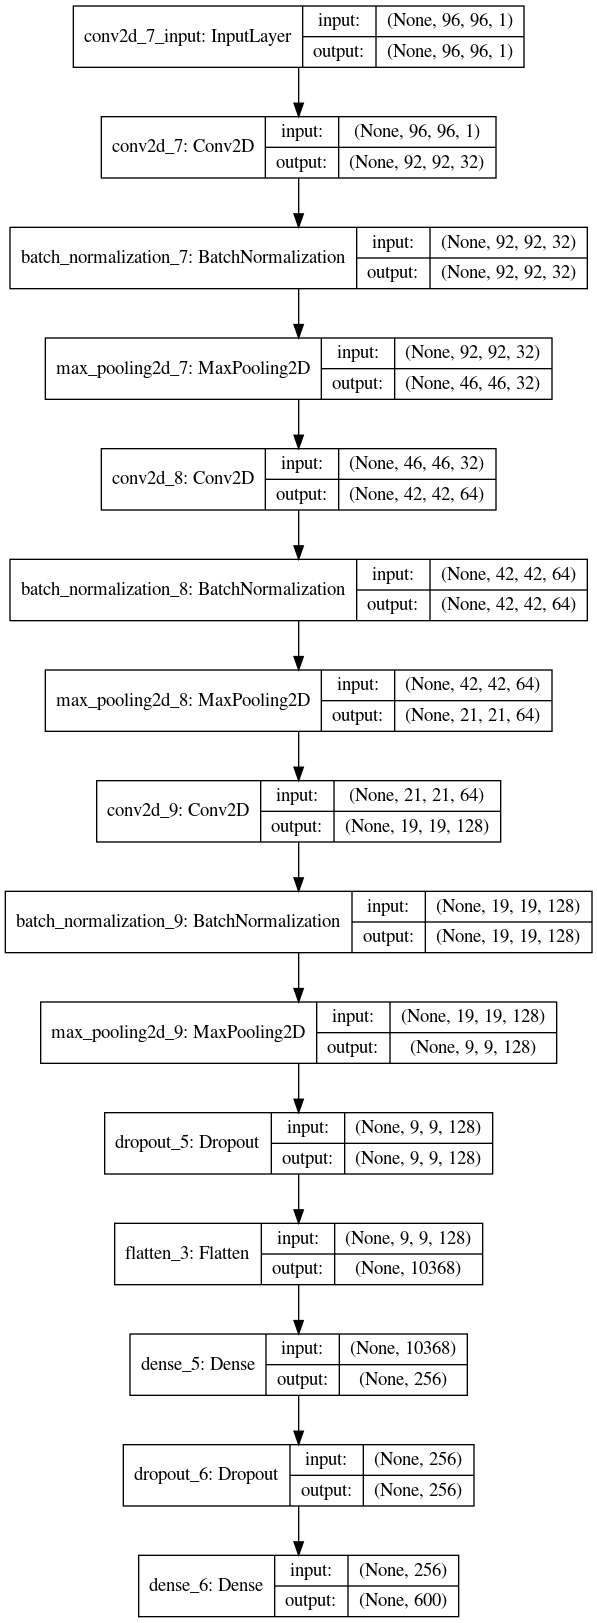

In [64]:
from keras.utils import plot_model
#Plot Id model graph in layers
plot_model(model, show_shapes=True, to_file='./model0.png')

In [65]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_data, train_labels, batch_size = 64, epochs =20, 
          validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 1)

Train on 30562 samples, validate on 7641 samples
Epoch 1/20
30562/30562 [==============================] - 19s 606us/step - loss: 6.4373 - accuracy: 0.0098 - val_loss: 7.1792 - val_accuracy: 0.0054
Epoch 2/20
30562/30562 [==============================] - 17s 573us/step - loss: 5.1455 - accuracy: 0.1339 - val_loss: 4.2118 - val_accuracy: 0.3467
Epoch 3/20
30562/30562 [==============================] - 17s 568us/step - loss: 2.7141 - accuracy: 0.5027 - val_loss: 2.1360 - val_accuracy: 0.6978
Epoch 4/20
30562/30562 [==============================] - 18s 574us/step - loss: 1.3046 - accuracy: 0.7612 - val_loss: 1.3193 - val_accuracy: 0.8214
Epoch 5/20
30562/30562 [==============================] - 17s 559us/step - loss: 0.7180 - accuracy: 0.8786 - val_loss: 0.9338 - val_accuracy: 0.8759
Epoch 6/20
30562/30562 [==============================] - 17s 567us/step - loss: 0.4653 - accuracy: 0.9306 - val_loss: 0.7618 - val_accuracy: 0.9045
Epoch 7/20
30562/30562 [==============================] -

(0.0, 1.0)

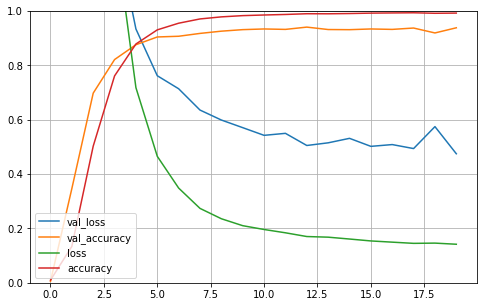

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

In [67]:
test_images, test_labels = [], []
 
    
    
for label, feature in test:
    test_images.append(feature)
    test_labels.append(label)
    
test_images = np.array(test_images).reshape(-1, img_size, img_size, 1)
test_images = test_images / 255.0

In [99]:
test_images_mCR, test_labels_mCR = [], []
test_images_mZcut, test_labels_mZcut = [], []
test_images_mObl, test_labels_mObl = [], []
 
    
    
for label, feature in Medium_data_CR:
    test_images_mCR.append(feature)
    test_labels_mCR.append(label)
    
test_images_mCR = np.array(test_images_mCR).reshape(-1, img_size, img_size, 1)
test_images_mCR = test_images_mCR / 255.0

for label, feature in Medium_data_Zcut:
    test_images_mZcut.append(feature)
    test_labels_mZcut.append(label)
    
test_images_mZcut = np.array(test_images_mZcut).reshape(-1, img_size, img_size, 1)
test_images_mZcut = test_images_mZcut / 255.0

for label, feature in Medium_data_Obl:
    test_images_mObl.append(feature)
    test_labels_mObl.append(label)
    
test_images_mObl = np.array(test_images_mObl).reshape(-1, img_size, img_size, 1)
test_images_mObl = test_images_mObl / 255.0

In [110]:
print(test_images.shape)

test_images_gauss = []
test_images_sp = []
test_images_poisson = []
test_images_speckle = []

for image in test_images:
    test_images_gauss.append(noisy("gauss", image))
    test_images_sp.append(noisy("s&p", np.reshape(image,(96, 96))).reshape(96, 96, 1))
    test_images_poisson.append(noisy("poisson", image))
    test_images_speckle.append(noisy("speckle", image))
test_images_gauss = np.array(test_images_gauss)
test_images_sp = np.array(test_images_sp)
test_images_poisson = np.array(test_images_poisson)
test_images_speckle = np.array(test_images_speckle)



# print(test_images[0])
# print(test_images_gauss[0])
print(test_images_sp[0])
# print(test_images_poisson[0])
# print(test_images_speckle[0])

(6000, 96, 96, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


[[[0.62745098]
  [0.61960784]
  [0.61960784]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.62745098]
  [0.41176471]
  [0.4745098 ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.62745098]
  [0.41176471]
  [1.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]


In [70]:
del test

In [71]:
test_labels  = to_categorical(test_labels, num_classes = 600)

In [100]:
test_labels_mCR = to_categorical(test_labels_mCR, num_classes = 600)
test_labels_mZcut = to_categorical(test_labels_mZcut, num_classes = 600)
test_labels_mObl = to_categorical(test_labels_mObl, num_classes = 600)

In [101]:
model.evaluate(train_data, train_labels)

38203/38203 [==============================] - 10s 255us/step


[0.18270743121945557, 0.9875664114952087]

In [72]:
model.evaluate(test_images_gauss, test_labels)

6000/6000 [==============================] - 2s 268us/step


[9.799467328389486, 0.043666668236255646]

In [111]:
model.evaluate(test_images_sp, test_labels)

6000/6000 [==============================] - 1s 246us/step


[0.26914305182298026, 0.9779999852180481]

In [74]:
model.evaluate(test_images_poisson, test_labels)

6000/6000 [==============================] - 2s 262us/step


[0.2798218384583791, 0.9766666889190674]

In [75]:
model.evaluate(test_images_speckle, test_labels)

6000/6000 [==============================] - 1s 244us/step


[26.20960385131836, 0.005499999970197678]

In [102]:
model.evaluate(test_images_mCR , test_labels_mCR)

5516/5516 [==============================] - 2s 274us/step


[0.7245054021747843, 0.8914068341255188]

In [103]:
model.evaluate(test_images_mZcut , test_labels_mZcut)

5612/5612 [==============================] - 2s 268us/step


[0.37938265658580483, 0.9595509767532349]

In [104]:
model.evaluate(test_images_mObl , test_labels_mObl)

5939/5939 [==============================] - 1s 245us/step


[0.3765268297930281, 0.9611045718193054]

### 以下先不看Try Not using any noise to train the data

In [ ]:
Real_path = "../input/socofing/SOCOFing/Real"
test = loading_data(Real_path, train = False)

# separate the no noise data into train and test
train = test[0:5000]
test = test[5000:6000]

In [ ]:
import random
random.shuffle(train)
random.shuffle(test)

In [ ]:
img, labels = [], []
for label, feature in train:
    labels.append(label)
    img.append(feature)
train_data = np.array(img).reshape(-1, img_size, img_size, 1)
train_data = train_data / 255.0 # normalize

from keras.utils.np_utils import to_categorical
train_labels = to_categorical(labels, num_classes = 5)

del train

In [ ]:
train_data.shape

In [ ]:
train_labels.shape

In [ ]:
len(test)

In [ ]:
model.compile(optimizer = optimizers.Adam(1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_data, train_labels, batch_size = 128, epochs = 30, 
          validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 1)

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

In [ ]:
test_images, test_labels = [], []

for label, feature in test:
    test_images.append(feature)
    test_labels.append(label)
    
test_images = np.array(test_images).reshape(-1, img_size, img_size, 1)
test_images = test_images / 255.0

del test

test_labels  = to_categorical(test_labels, num_classes = 5)

In [ ]:
test_images.shape
test_labels.shape

In [ ]:
model.evaluate(test_images, test_labels)